In [1]:
import numpy as np
import math
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
I_values=np.linspace(100,1099,100)
sx=np.linspace(-0.02,0.02,64)  # x-position of the testing point
sy=np.linspace(-0.02,0.02,64)  # y-position of the testing point
wx=np.linspace(-0.1,0.1,20)
H=0.015
mu_0 = 4 * math.pi * 1e-7  # Permeability of free space

In [4]:

# Create a list to store the rows of data

fm=[]
# Loop over the I and R values and calculate the corresponding B values
for n in wx:
  for I in I_values:
    mm=[]
    for m in sx:
      mmm=[]
      for j in sy:
        R=np.sqrt(H**2+abs(n-m)**2)
        B = mu_0 * I / (2 * math.pi * R)
        mmm.append(B)
      mm.append(mmm)
    fm.append(mm)


In [5]:
shape = np.shape(fm)
shape

(2000, 64, 64)

In [6]:
I_grid, wx_grid = np.meshgrid(I_values, wx)

# Reshape the grids into 1D arrays
I_array = I_grid.reshape(-1)
wx_array = wx_grid.reshape(-1)

# Stack the arrays horizontally to create a 2D array with shape (2000, 2)
combined_array = np.hstack((wx_array.reshape(-1, 1), I_array.reshape(-1, 1)))
combined_array

array([[-1.00000000e-01,  1.00000000e+02],
       [-1.00000000e-01,  1.10090909e+02],
       [-1.00000000e-01,  1.20181818e+02],
       ...,
       [ 1.00000000e-01,  1.07881818e+03],
       [ 1.00000000e-01,  1.08890909e+03],
       [ 1.00000000e-01,  1.09900000e+03]])

In [7]:
np.shape(combined_array)

(2000, 2)

In [8]:
def custom_loss(y_true, y_pred):
    i_true = tf.expand_dims(y_true[:, 0], axis=-1)
    wx_true = tf.expand_dims(y_true[:, 1], axis=-1)
    i_pred = y_pred[:, 0]
    wx_pred = y_pred[:, 1]
    loss_i = tf.keras.losses.mean_squared_error(i_true, i_pred)
    loss_wx = tf.keras.losses.mean_squared_error(wx_true, wx_pred)
    return loss_i + loss_wx



In [10]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
matrix_size = 64
epochs = 60
input_shape = (64, 64, 1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=20)
# Define the output shape
output_shape = (2,)

# Define the model
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(output_shape[0], activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


# Generate some example data
X = fm # Input data
y = combined_array # Output data
y = np.array(y)
# Preprocess the data
X = np.array(X)

#X = X.reshape((2000, 4096)) # Reshape to 1D vectors
X = X / np.max(X) # Normalize the input data

y = y / np.max(y) # Scale the output data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
# Create the model
model.summary()

history = model.fit(X_train, y_train, callbacks=[es], shuffle=True, epochs=epochs, validation_split=0.2)

# Make predictions on new data
y_pred = model.predict(X_test) # Predict the output data


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [11]:
y_pred

array([[9.3856318e-07, 6.0531586e-01],
       [1.1141226e-05, 6.1390668e-01],
       [1.4675675e-06, 3.8758853e-01],
       ...,
       [1.5491200e-07, 5.4353553e-01],
       [1.1472153e-03, 3.6395204e-01],
       [2.5540774e-03, 5.1581907e-01]], dtype=float32)

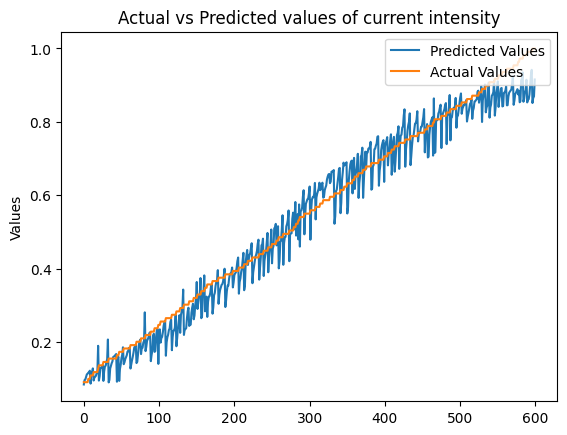

In [12]:
paired_array = list(zip(y_test[:, 1], y_pred[:, 1]))

# Sorting the paired array by the first element in each subarray using sorted()
sorted_array = sorted(paired_array)
y_test1, y_pred1 = zip(*sorted_array)
plt.plot(y_pred1, label='Predicted Values')
plt.plot(y_test1, label='Actual Values')
plt.ylabel("Values")
plt.title("Actual vs Predicted values of current intensity")
plt.legend(loc="upper right")

plt.show()

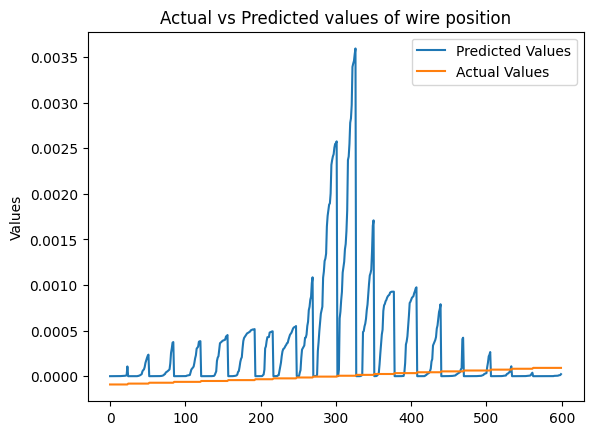

In [13]:
paired_array = list(zip(y_test[:, 0], y_pred[:, 0]))

# Sorting the paired array by the first element in each subarray using sorted()
sorted_array = sorted(paired_array)
y_test0, y_pred0 = zip(*sorted_array)
plt.plot(y_pred0, label='Predicted Values')
plt.plot(y_test0, label='Actual Values')
plt.ylabel("Values")
plt.title("Actual vs Predicted values of wire position")
plt.legend(loc="upper right")

plt.show()